# donwload data

In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download -d irkaal/foodcom-recipes-and-reviews -f recipes.parquet
!kaggle datasets download -d irkaal/foodcom-recipes-and-reviews -f reviews.parquet

Dataset URL: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews
License(s): CC0-1.0
100% 170M/170M [00:03<00:00, 77.7MB/s]
100% 170M/170M [00:03<00:00, 49.7MB/s]
Dataset URL: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews
License(s): CC0-1.0
 98% 161M/164M [00:02<00:00, 82.7MB/s]
100% 164M/164M [00:02<00:00, 76.8MB/s]


In [3]:
!unzip recipes.parquet.zip
!rm recipes.parquet.zip
!unzip reviews.parquet.zip
!rm reviews.parquet.zip

Archive:  recipes.parquet.zip
  inflating: recipes.parquet         
Archive:  reviews.parquet.zip
  inflating: reviews.parquet         


# Libs

In [4]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import pickle as pkl
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [5]:
recipes = pd.read_parquet('recipes.parquet')
reviews = pd.read_parquet('reviews.parquet')

In [27]:
# hay 7368 ingredientes diferentes
all_ingredients = set()
for i in range(len(recipes)):
    all_ingredients.update(recipes["RecipeIngredientParts"].loc[i])
# y 9 elementos nutricionales
nutrition_facts = [
    'Calories', 'FatContent','SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
    'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent'
]
len(all_ingredients), len(nutrition_facts)

(7368, 9)

In [7]:
users_amount, recipes_amount = len(reviews["AuthorId"].unique()), len(reviews["RecipeId"].unique())
users_amount, recipes_amount

(271907, 271678)

# Base NCF

## model

In [8]:
# Extraido en gran parte del práctico de NCF
class NeuralCollaborativeFilteringNN(nn.Module):
    def __init__(self, user_sz: tuple, item_sz:tuple, y_range=(0,5.5), n_act=100, n_factors = 50):
        super().__init__()
        number_of_users = user_sz[0]
        number_of_items = item_sz[0]
        number_user_features = user_sz[1]
        number_item_features = item_sz[1]
        self.user_factors_mf = nn.Embedding(number_of_users, n_factors)
        self.user_factors_mlp = nn.Embedding(number_of_users, number_user_features)
        self.item_factors_mf = nn.Embedding(number_of_items, n_factors)
        self.item_factors_mlp = nn.Embedding(number_of_items, number_item_features)

        self.y_range = y_range

        self.user_bias = nn.Embedding(number_of_users, 1)
        self.item_bias = nn.Embedding(number_of_items, 1)

        self.MLPLayers = nn.Sequential(
            nn.Linear(number_user_features + number_item_features, n_act),
            nn.ReLU(),
        )

        self.final_layer = nn.Linear(n_act + n_factors, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        user_vector_mf = self.user_factors_mf(x[:,0])
        user_vector_mlp = self.user_factors_mlp(x[:,0])
        item_vector_mf = self.item_factors_mf(x[:,1])
        item_vector_mlp = self.item_factors_mlp(x[:,1])
        # TODO: implementar resto del código. Por favor incluir comentarios
        # para que quede claro el propósito de cada línea (o conjunto de líneas)

        # Hacemos el element-wise product y le sumamos el bias
        user_bias = self.user_bias(x[:,0])
        item_bias = self.item_bias(x[:,1])
        mf_output = user_vector_mf * item_vector_mf
        mf_output += user_bias + item_bias

        # Concatenamos los vectores de embedding de MLP de usuario e ítem
        mlp_input = torch.cat((user_vector_mlp, item_vector_mlp), dim=1)

        # Pasamos la concatenación por la red MLP
        mlp_output = self.MLPLayers(mlp_input)

        # Concatenamos la salida del MLP con el resultado del modelo MF
        final_input = torch.cat((mlp_output, mf_output), dim=1)

        # Pasamos la concatenación por la capa final para obtener la predicción
        output = self.final_layer(final_input)

        return self.sigmoid(output) * (self.y_range[1] - self.y_range[0]) + self.y_range[0]


## dataset

 se genera un mapeo de los ids ya que los id de usuarios y autores son aleatorios

In [9]:
reviews = reviews.sample(frac=0.4)
reviews.reset_index(drop=True, inplace=True)

In [10]:
len(reviews)

560793

In [11]:
users_ids_map = {user_id: i for i, user_id in enumerate(reviews['AuthorId'].unique())}
recipes_ids_map = {recipe_id: i for i, recipe_id in enumerate(reviews['RecipeId'].unique())}

In [12]:
recipes_amount = len(reviews['RecipeId'].unique())
users_amount = len(reviews['AuthorId'].unique())
recipes_amount, users_amount

(178273, 138321)

In [13]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews):
        self.reviews = reviews
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        user_id = users_ids_map[review['AuthorId']]
        recipe_id = recipes_ids_map[review['RecipeId']]
        rating = review['Rating'].astype(float)
        return torch.tensor([user_id, recipe_id], device=device), torch.tensor(rating, device=device, dtype=torch.float32)

In [19]:
reviews_dataloader = DataLoader(ReviewsDataset(reviews), batch_size=32, shuffle=True)

## Train

In [24]:
user_sz = (users_amount, 256)
item_sz = (recipes_amount, 256)

ncf_model = NeuralCollaborativeFilteringNN(
    user_sz=user_sz,
    item_sz=item_sz,
    n_act = 50,
    n_factors = 10)
ncf_model.to(device)

NeuralCollaborativeFilteringNN(
  (user_factors_mf): Embedding(138321, 10)
  (user_factors_mlp): Embedding(138321, 256)
  (item_factors_mf): Embedding(178273, 10)
  (item_factors_mlp): Embedding(178273, 256)
  (user_bias): Embedding(138321, 1)
  (item_bias): Embedding(178273, 1)
  (MLPLayers): Sequential(
    (0): Linear(in_features=512, out_features=50, bias=True)
    (1): ReLU()
  )
  (final_layer): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [25]:
optimizer = torch.optim.Adam(ncf_model.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()

In [26]:
ncf_model.train()
loop = tqdm(enumerate(reviews_dataloader), total=len(reviews_dataloader))
avg_loss = 0
losses_base_ncf = []
for i, (user_item, rating) in loop:
    optimizer.zero_grad()
    output = ncf_model(user_item)
    loss = loss_func(output, rating)
    loss.backward()
    optimizer.step()
    avg_loss = (avg_loss * i + loss.item()) / (i + 1)
    losses_base_ncf.append(loss.item())
    loop.set_description(f'loss: {loss.item():.4f}, avg loss: {avg_loss:.4f}')

  0%|          | 0/17525 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

# Adding recipe features

## models

In [28]:
class RecipeEncoder(nn.Module):
    def __init__(self, n_nutrition_facts=9, n_ingredients=7368):
        super().__init__()
        self.encoder = nn.Linear(n_ingredients + n_nutrition_facts, 64)
    def forward(self, x):
        return self.encoder(x)


In [29]:
# Extraido en gran parte del práctico de NCF
class NeuralCollaborativeFilteringNN(nn.Module):
    def __init__(self, user_sz: tuple, item_sz:tuple, y_range=(0,5.5), n_act=100, n_factors = 50):
        super().__init__()
        number_of_users = user_sz[0]
        number_of_items = item_sz[0]
        number_user_features = user_sz[1]
        number_item_features = item_sz[1]
        self.user_factors_mf = nn.Embedding(number_of_users, n_factors)
        self.user_factors_mlp = nn.Embedding(number_of_users, number_user_features)
        self.item_factors_mf = nn.Embedding(number_of_items, n_factors)
        self.item_factors_mlp = nn.Embedding(number_of_items, number_item_features) # for the encoder
        self.recipe_encoder = RecipeEncoder() # ouputs 64 tensor embedding
        self.y_range = y_range

        self.user_bias = nn.Embedding(number_of_users, 1)
        self.item_bias = nn.Embedding(number_of_items, 1)

        self.MLPLayers = nn.Sequential(
            nn.Linear(number_user_features + number_item_features + 64, n_act),
            nn.ReLU(),
        )

        self.final_layer = nn.Linear(n_act + n_factors, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, recipe_features):
        user_vector_mf = self.user_factors_mf(x[:,0])
        user_vector_mlp = self.user_factors_mlp(x[:,0])
        item_vector_mf = self.item_factors_mf(x[:,1])
        item_vector_mlp = self.item_factors_mlp(x[:,1])
        recipe_features = self.recipe_encoder(recipe_features)
        # TODO: implementar resto del código. Por favor incluir comentarios
        # para que quede claro el propósito de cada línea (o conjunto de líneas)

        # Hacemos el element-wise product y le sumamos el bias
        user_bias = self.user_bias(x[:,0])
        item_bias = self.item_bias(x[:,1])
        mf_output = user_vector_mf * item_vector_mf
        mf_output += user_bias + item_bias

        # Concatenamos los vectores de embedding de MLP de usuario e ítem
        mlp_input = torch.cat((user_vector_mlp, item_vector_mlp, recipe_features), dim=1)

        # Pasamos la concatenación por la red MLP
        mlp_output = self.MLPLayers(mlp_input)

        # Concatenamos la salida del MLP con el resultado del modelo MF
        final_input = torch.cat((mlp_output, mf_output), dim=1)

        # Pasamos la concatenación por la capa final para obtener la predicción
        output = self.final_layer(final_input)

        return self.sigmoid(output) * (self.y_range[1] - self.y_range[0]) + self.y_range[0]

## dataset

In [42]:
class RecipeDataset(Dataset):
    def __init__(self, recipes):
        self.recipes = recipes
        self.recipes["RecipeId"] = self.recipes["RecipeId"].astype(int)
        self.nutrition_facts = 9
    def __len__(self):
        return len(self.recipes)
    def __getitem__(self, idx):
        recipe = self.recipes[self.recipes["RecipeId"] == idx]
        if len(recipe) == 0:
            print(f'id: {idx} not found')
            return None
        recipe_id = recipe["RecipeId"]
        nutrition = np.array(recipe[nutrition_facts].values.astype(float))
        if len(nutrition) == self.nutrition_facts:
            nutrition = np.zeros(self.nutrition_facts)

        max_nutrition = np.max(nutrition)
        nutrition = nutrition / max_nutrition if max_nutrition != 0 else np.zeros_like(nutrition) # normalizamos los valore nutricionales ya que generalmente son muy grandes
        ingredients = recipe["RecipeIngredientParts"]
        ingredients = torch.tensor([int(i in ingredients) for i in all_ingredients], device=device, dtype=torch.float32)
        nutrition =  torch.tensor(nutrition, device=device, dtype=torch.float32).squeeze()
        return torch.cat([ingredients, nutrition])


In [43]:
users_ids_map = {user_id: i for i, user_id in enumerate(reviews['AuthorId'].unique())}
recipes_ids_map = {recipe_id: i for i, recipe_id in enumerate(reviews['RecipeId'].unique())}

In [44]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews):
        self.reviews = reviews
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, idx):

        review = self.reviews.iloc[idx]
        user_id = users_ids_map[review['AuthorId']]
        recipe_id_default = review['RecipeId']
        recipe_id = recipes_ids_map[recipe_id_default]
        rating = review['Rating'].astype(float)
        return torch.tensor([user_id, recipe_id, recipe_id_default], device=device), torch.tensor(rating, device=device, dtype=torch.float32)

In [45]:
recipes.reset_index(drop=True, inplace=True)
recipe_dst = RecipeDataset(recipes)
def collate_fn(batch):
    user_item_idOld, rating = zip(*batch)
    user_item_idOld = torch.stack(user_item_idOld)
    old_ids = user_item_idOld[:, 2]
    user_item = user_item_idOld[:, :2]
    recipe_features = []
    for old_id in old_ids:
        recp = recipe_dst[old_id.item()]
        if recp is None: continue
        recipe_features.append(recp)

    rating = torch.stack(rating)
    recipe_features = torch.stack(recipe_features)
    return user_item, rating, recipe_features

In [46]:
reviews_dataloader = DataLoader(ReviewsDataset(reviews), batch_size=32, shuffle=True, collate_fn=collate_fn)


## TRAIN

In [47]:
user_sz = (users_amount, 256)
item_sz = (recipes_amount, 256)

ncf_model = NeuralCollaborativeFilteringNN(
    user_sz=user_sz,
    item_sz=item_sz,
    n_act = 50,
    n_factors = 10)
ncf_model.to(device)


NeuralCollaborativeFilteringNN(
  (user_factors_mf): Embedding(138321, 10)
  (user_factors_mlp): Embedding(138321, 256)
  (item_factors_mf): Embedding(178273, 10)
  (item_factors_mlp): Embedding(178273, 256)
  (recipe_encoder): RecipeEncoder(
    (encoder): Linear(in_features=7377, out_features=64, bias=True)
  )
  (user_bias): Embedding(138321, 1)
  (item_bias): Embedding(178273, 1)
  (MLPLayers): Sequential(
    (0): Linear(in_features=576, out_features=50, bias=True)
    (1): ReLU()
  )
  (final_layer): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [48]:
users_ids_map = {user_id: i for i, user_id in enumerate(reviews['AuthorId'].unique())}
recipes_ids_map = {recipe_id: i for i, recipe_id in enumerate(reviews['RecipeId'].unique())}

In [49]:
optimizer = torch.optim.Adam(ncf_model.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()

In [50]:
ncf_model.train()
loop = tqdm(enumerate(reviews_dataloader), total=len(reviews_dataloader))
avg_loss = 0
losses_cb_ncf = []
for i, (user_item, rating, recipe_features) in loop:
    if i >= 400:
        break

    optimizer.zero_grad()
    output = ncf_model(user_item, recipe_features)
    loss = loss_func(output.squeeze(), rating)
    loss.backward()
    optimizer.step()
    losses_cb_ncf.append(loss.item())
    avg_loss = (avg_loss * i + loss.item()) / (i + 1)
    loop.set_description(f'loss: {loss.item():.4f}, Avg Loss: {avg_loss:.4f}')


  0%|          | 0/17525 [00:00<?, ?it/s]

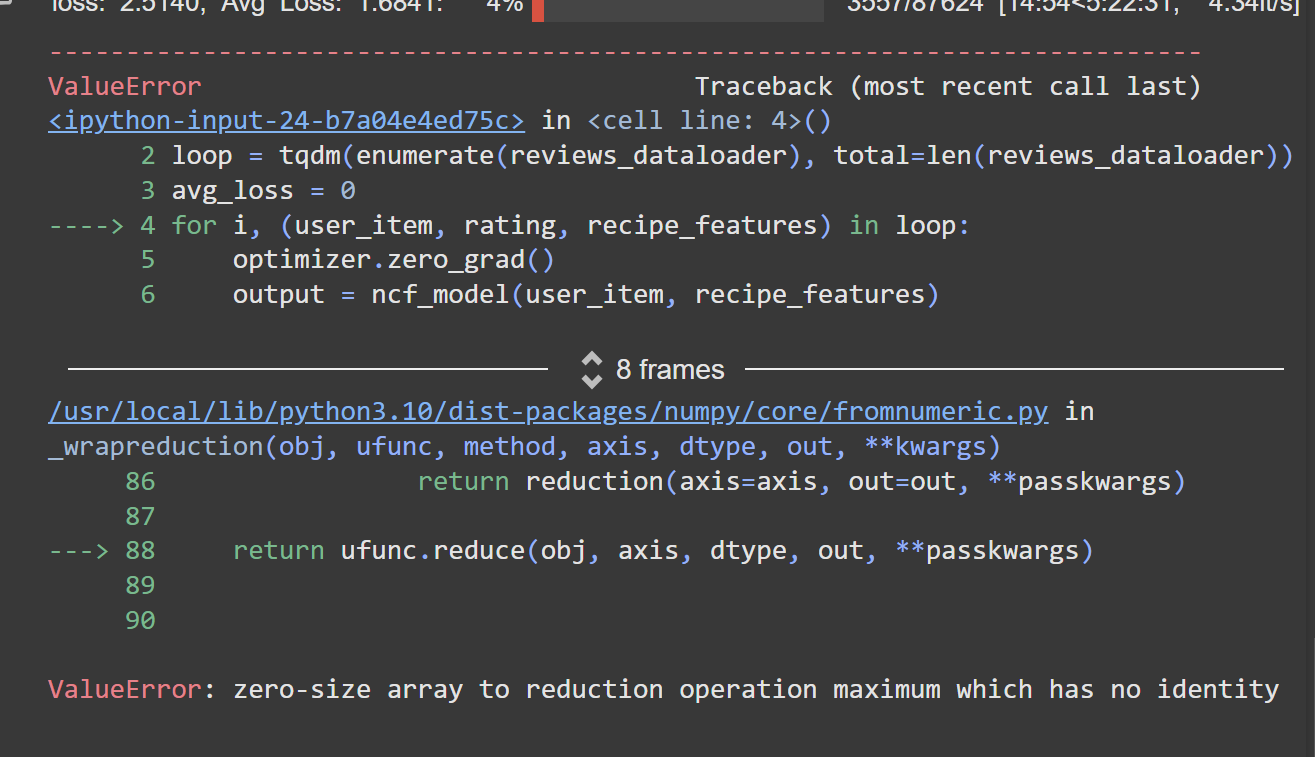

Este error es importante, revisar recipes tiene todos las recetas de reviews

In [ ]:
torch.save(ncf_model.state_dict(), 'ncf_model.pth')

# Evaluation

In [51]:
# https://www.kdnuggets.com/how-to-compute-moving-averages-using-numpy
def moving_average(data, win_size):
    weights = np.ones(win_size) / win_size
    return np.convolve(data, weights, mode='valid')


In [52]:
import matplotlib.pyplot as plt

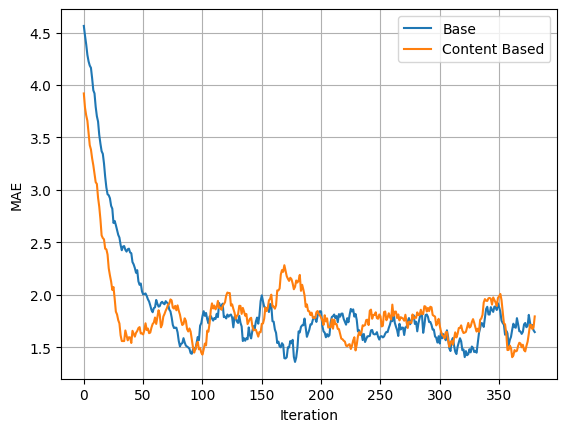

In [58]:
win_size = 20
plt.plot(moving_average(losses_base_ncf, win_size), label="Base")
plt.plot(moving_average(losses_cb_ncf, win_size), label="Content Based")
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.legend()
plt.show()